NMFk example: Feature extraction
-----

An example problem demonstrating how **NMFk** can be applied to extract and clasify features and sensors observing these mixed features.

This type of analysis is related to **blind source separation**

Applying **NMFk**, we can automatically:

- identify the number of the unknown mixed signatures in dataset 
- estimate the shape of the unknown mixed signatures
- estimate how the signatures are mixed at each sensor
- clasify sensors based on how they observe (are impacted) the extracted features.

If **NMFk** is not installed, first execute in the Julia REPL: `import Pkg; Pkg.add("NMFk"); Pkg.add("Mads")`.

In [1]:
import Revise
import NMFk
import Mads
import Random

Random.seed!(2021)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1047027516803802308\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11893526307498903598\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1047027516803802308\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/vvv/.julia/packages/PyPlot/XHEG0/src/init.jl:118


MersenneTwister(2021)

Let us generate 4 random signals with legnth of 100 (this can be considered as 100 ):

In [2]:
s1 = (sin.(0.05:0.05:5) .+1) ./ 2
s2 = (sin.(0.3:0.3:30) .+ 1) ./ 2
s3 = (sin.(0.5:0.5:50) .+ 1) ./ 2
s4 = rand(100)
W = [s1 s2 s3 s4]

100×4 Matrix{Float64}:
 0.52499      0.64776     0.739713    0.647247
 0.549917     0.782321    0.920735    0.12358
 0.574719     0.891663    0.998747    0.992042
 0.599335     0.96602     0.954649    0.767448
 0.623702     0.998747    0.799236    0.616215
 0.64776      0.986924    0.57056     0.836668
 0.671449     0.931605    0.324608    0.399988
 0.694709     0.837732    0.121599    0.60606
 0.717483     0.71369     0.0112349   0.192925
 0.739713     0.57056     0.0205379   0.170886
 0.761344     0.421127    0.14723     0.0299662
 0.782321     0.27874     0.360292    0.490479
 0.802593     0.156117    0.60756     0.669716
 ⋮                                    
 0.0171135    0.999997    0.747443    0.627557
 0.0112349    0.978188    0.925452    0.0639847
 0.00657807   0.913664    0.999295    0.389393
 0.0031545    0.812189    0.950894    0.662159
 0.000972781  0.682826    0.792098    0.162863
 3.83712e-5   0.537133    0.561787    0.816227
 0.000353606  0.388122    0.316347    0.08008

The singals look like this:

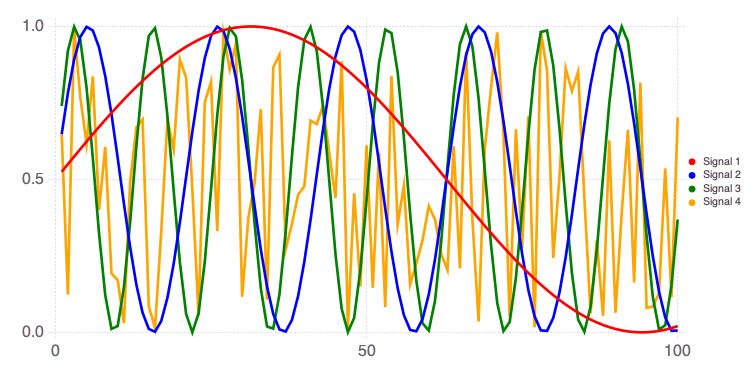

In [3]:

Mads.plotseries(W)

Now we can mix the signals in matrix `W` to produce a data matrix `X` representing data collected at 10 sensors (e.g., measurement devices or wells at different locations).

Each of the 10 sensors is observing some mixture of the 4 signals in `W`.

The way the 4 signals are mixed at the sensors is represented by the mixing matrix `H`.

Let us define the mixing matrix `H` as:

In [4]:
H = [1 5 0 0 1 1 2 1 0 2; 0 1 1 5 2 1 0 0 2 3; 3 0 0 1 0 1 0 5 4 3; 1 1 4 1 5 0 1 1 5 3]

4×10 Matrix{Int64}:
 1  5  0  0  1  1  2  1  0  2
 0  1  1  5  2  1  0  0  2  3
 3  0  0  1  0  1  0  5  4  3
 1  1  4  1  5  0  1  1  5  3

Each column of the `H` matrix defines how the 3 signals are represented in each sensors.

For example, the first sensor (column 1 above) detects only Signals 1 and 3; Signal 2 is missing because `H[2,1]` is equal to zero.

The second sensor (column 2 above) detects Signals 1 and 2; Signal 3 is missing because `H[3,2]` is equal to zero.

The entries of `H` matrix also define the proportions at which the signals are mixed.

For example, the first sensor (column 1 above) detects Signal 3 times stronger than Signal 1.

The data matrix `X` is formed by multiplying `W` and `H` matrices. `X` defines the actual data observed.

In [5]:
X = W * H

100×10 Matrix{Float64}:
 3.39137   3.91995   3.23675   4.62576   …  4.8708     7.49061   7.15414
 3.4357    3.65549   1.27664   4.95592      5.27717    5.86549   6.57974
 4.563     4.7573    4.85983   6.44911      6.5605    10.7385    9.7968
 4.23073   4.73014   4.03581   6.55219      6.14003    9.58787   9.26302
 3.63763   4.73347   3.46361   6.40919      5.2361     8.27552   8.49
 3.19611   5.06239   4.33359   6.34185   …  4.33723    8.43943   8.47797
 2.04526   4.68884   2.53156   5.38262      2.69448    5.16158   6.3115
 1.66557   4.91734   3.26197   4.91632      1.90876    5.19216   6.08559
 0.944113  4.49403   1.48539   3.77261      0.966583   2.43695   4.18852
 0.972213  4.44001   1.25411   3.04422      1.01329    2.0777    3.76538
 1.233     4.25781   0.540992  2.28283   …  1.52746    1.581     3.31766
 2.35368   4.68083   2.24066   2.24447      3.07426    4.45105   4.95318
 3.29499   4.8388    2.83498   2.05786      4.51011    6.09105   5.90537
 ⋮                              

The data matrix `X` looks like this:

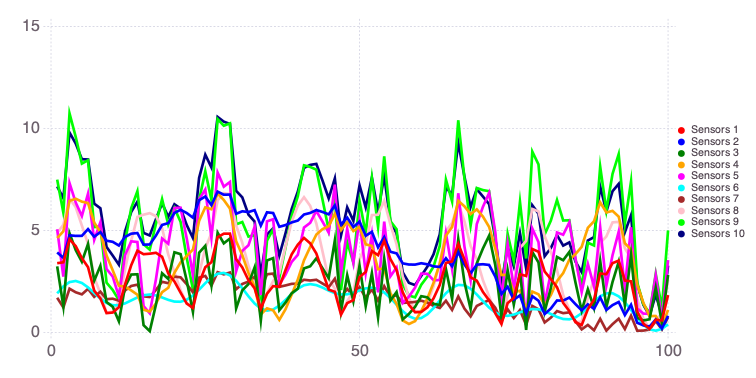

In [6]:
Mads.plotseries(X; name="Sensors")

Now, we can assume that we only know the data matrix `X` and the `W` and `H` matrices are unknown.

We can execute **NMFk** and analyze the data matrix `X`.

**NMFk** will automatically:

- identify the number of the unknown mixed signals in `X` 
- estimate the shape of the unknown mixed signals (i.e., estimate the entries of `W` matrix)
- estimate how the signals are mixed at the 5 sensors (i.e., estimate the entries of `H` matrix)

This can be done based only on the information in `X`:

In [7]:
nkrange=2:10
We, He, fitquality, robustness, aic, kopt = NMFk.execute(X, nkrange; save=false, method=:simple);


OF: min 548.7422582028156 max 580.5440039409768 mean 562.8566553254008 std 14.795160329024531
Worst correlation by columns: 0.49656990847609483
Worst correlation by rows: 0.6933647679055946
Worst covariance by columns: 0.055916982680008095
Worst covariance by rows: 0.32212576245424585
Worst norm by columns: 0.218926345183287
Worst norm by rows: 0.5820116755178509
Signals:  2 Fit:     548.7423 Silhouette:     0.721058 AIC:    -160.1264

OF: min 194.4904756107191 max 195.72210922217826 mean 195.05832746522387 std 0.3568209408545568
Worst correlation by columns: 0.7973657126701852
Worst correlation by rows: 0.8485227941925483
Worst covariance by columns: 0.11006980619827106
Worst covariance by rows: 0.3405091353610321
Worst norm by columns: 0.23735564397861872
Worst norm by rows: 0.7186549773672026
Signals:  3 Fit:     194.4905 Silhouette:    0.9635512 AIC:    -977.3721

OF: min 0.024567539643564267 max 0.2557292346363618 mean 0.07825162953367235 std 0.06955207877093642
Worst correlation

┌ Info: Results
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:15
┌ Info: Optimal solution: 4 signals
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:20


**NMFk** returns the estimated optimal number of signals `kopt` which in this case, as expected, is equal to 3.

**NMFk** also returns estimates of matrices `W` and `H`.

Here the estimates of matrices W and H are stored as `We` and `He` objects.

`We[kopt]` and `He[kopt]` are scaled versions of the original `W` and `H` matrices:

In [8]:
We[kopt]

100×4 Matrix{Float64}:
 12.6746    10.3151     6.77863      13.5874
 15.3779    12.6577     7.08556       2.13378
 17.1228    14.195      7.40271      20.9294
 16.2405    15.3711     7.73907      16.0439
 13.548     15.803      8.08658      12.7956
  9.84764   15.3966     8.43585      17.6508
  5.51722   14.4668     8.78552       8.25139
  2.27513   12.805      9.11285      12.8047
  0.257121  10.8949     9.42496       3.89097
  0.466265   8.67362    9.70333       3.44009
  2.57475    6.46544    9.95522       0.381131
  6.46818    4.28512   10.1719       10.3415
 10.7672     2.5035    10.382        14.1851
  ⋮                                  
 12.4706    15.9274     0.179814     13.1574
 15.1589    15.8378     3.39669e-6    0.962523
 16.5977    14.8251     6.06528e-12   7.92237
 15.9713    13.1277     2.12615e-13  13.8576
 13.0935    11.1416     4.17574e-15   3.06862
  9.63637    8.53135    7.08823e-12  17.3971
  5.1901     6.24485    4.17574e-15   1.53127
  1.88743    3.93757    0.02

In [9]:
He[kopt]

4×10 Matrix{Float64}:
 0.180266    0.00192653  8.8627e-5   …  0.299463    0.23666     0.17462
 0.00507919  0.0629675   0.0673405      0.00815786  0.137707    0.198628
 0.0722585   0.384978    0.00337183     0.0689723   5.66632e-5  0.153851
 0.0415675   0.0467733   0.185329       0.038596    0.22572     0.136098

Note that the order of columns ('signals') in `W` and `We[kopt]` are not expected to match.

Also note that the order of rows ('sensors') in `H` and `He[kopt]` are also not expected to match.

The estimated order of 'signals' will be different every time the code is executed.

Below are plots providing comparisons between the original and estimated `W` an `H` matrices.


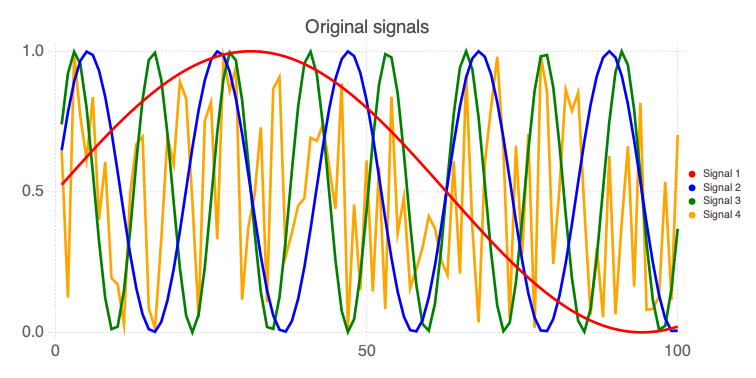

In [10]:
Mads.plotseries(W; title="Original signals")

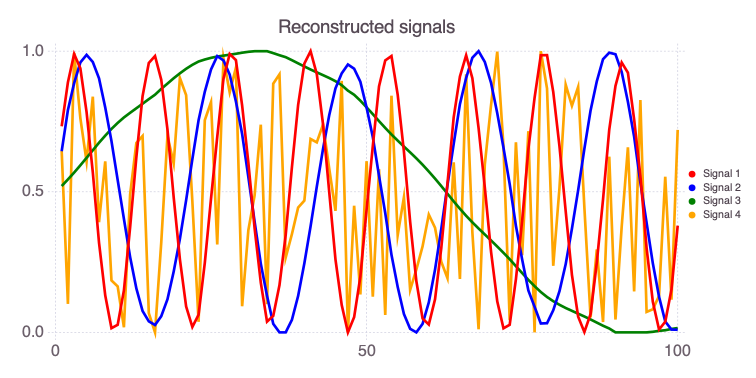

In [11]:
Mads.plotseries(We[kopt] ./ maximum(We[kopt]; dims=1); title="Reconstructed signals")

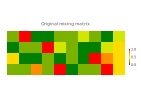

In [12]:
NMFk.plotmatrix(H ./ maximum(H); title="Original mixing matrix")

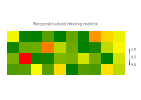

In [13]:
NMFk.plotmatrix(He[kopt] ./ maximum(He[kopt]); title="Reconstructed mixing matrix")

Signal importance (high->low): [2, 1]


┌ Info: Number of signals: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:164
┌ Info: Sensors (signals=2)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:168
┌ Warning: File ./Hmatrix-2-2_10-1000.jld does not exist! Robust k-means analysis will be executed ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:74
┌ Info: Robust k-means analysis results are saved in file ./Hmatrix-2-2_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:100
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: File ./Wmatrix-2-2_100-1000.jld does not exist! Robust k-means analysis will be executed ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:74
┌ Info: Robust k-means analysis results are saved in file ./Wmatrix-2-2_100-

8×2 Matrix{Any}:
 "s9"   1.0
 "s10"  0.788439
 "s8"   0.718571
 "s4"   0.537016
 "s5"   0.46532
 "s1"   0.456592
 "s3"   0.335853
 "s6"   0.195421

┌ Info: Signal B -> B Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A (S2) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292


2×2 Matrix{Any}:
 "s2"  1.0
 "s7"  0.422131

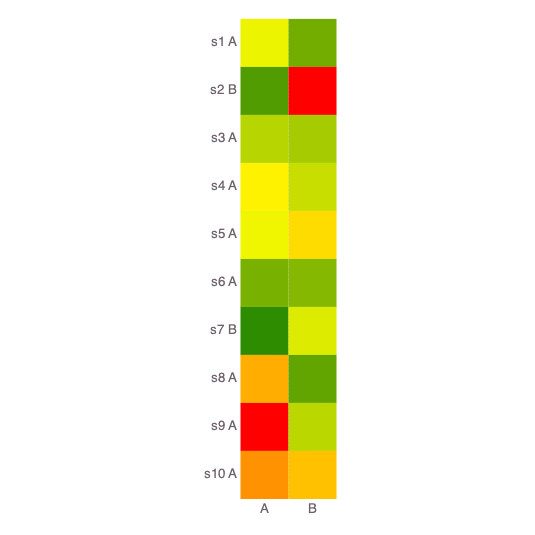

┌ Info: Signal B (S1) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292


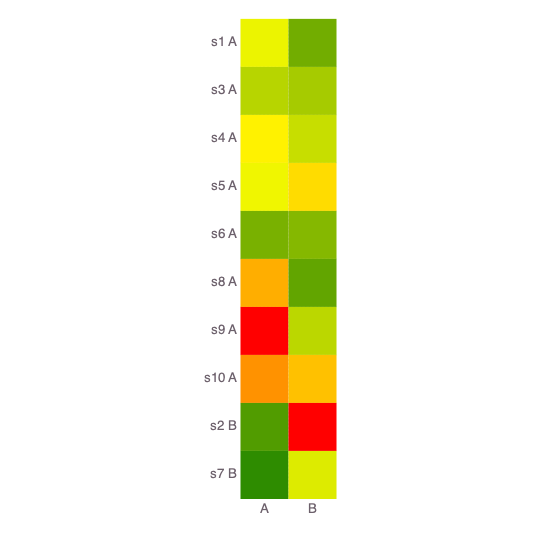

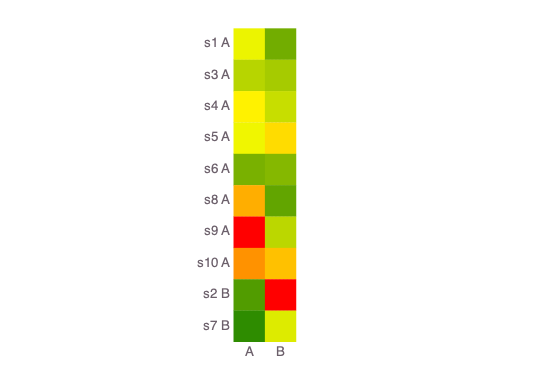

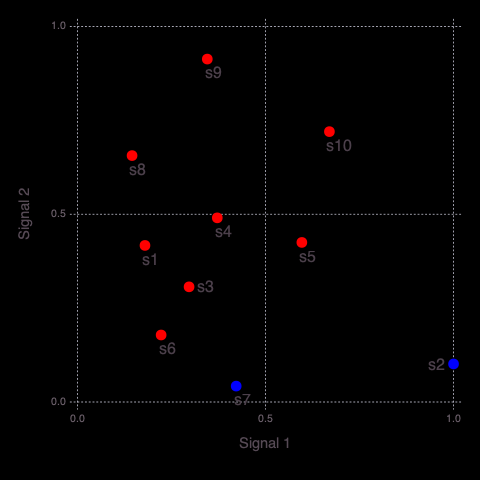

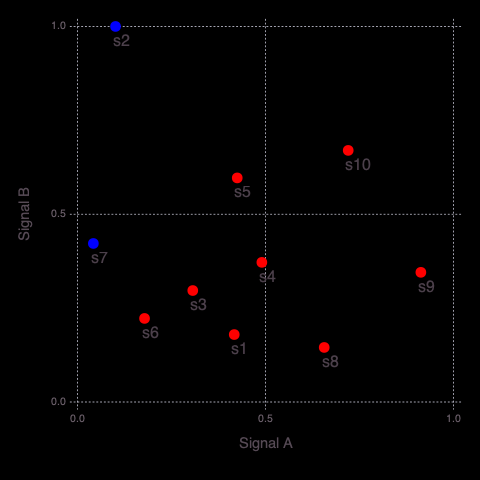

64×2 Matrix{Any}:
 "t66"  1.0
 "t3"   0.995616
 "t92"  0.939067
 "t4"   0.907584
 "t27"  0.89612
 "t28"  0.894106
 "t91"  0.886251
 "t29"  0.88556
 "t89"  0.872883
 "t78"  0.826028
 "t67"  0.792849
 "t79"  0.781565
 "t5"   0.775981
 ⋮      
 "t16"  0.416932
 "t63"  0.408192
 "t77"  0.399223
 "t74"  0.374316
 "t75"  0.334599
 "t85"  0.293
 "t95"  0.292407
 "t86"  0.252929
 "t98"  0.20827
 "t96"  0.155649
 "t99"  0.117014
 "t97"  0.0795985

36×2 Matrix{Any}:
 "t46"  1.0
 "t24"  0.949794
 "t25"  0.921673
 "t21"  0.911409
 "t48"  0.876323
 "t22"  0.87149
 "t35"  0.844379
 "t20"  0.833659
 "t33"  0.828204
 "t36"  0.811971
 "t45"  0.807707
 "t47"  0.7906
 "t44"  0.769936
 ⋮      
 "t12"  0.584323
 "t38"  0.557434
 "t37"  0.554392
 "t11"  0.509121
 "t72"  0.50314
 "t60"  0.484285
 "t61"  0.461324
 "t59"  0.427494
 "t62"  0.399923
 "t58"  0.37513
 "t57"  0.339269
 "t73"  0.297573

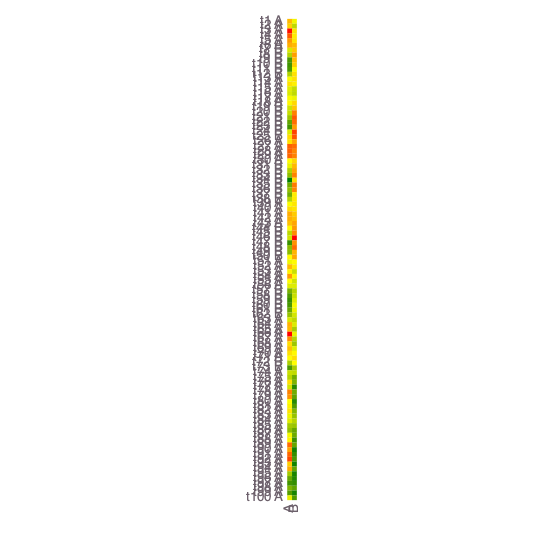

┌ Info: Times (signals=2)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:350
┌ Info: Signal A (S2) Count: 64
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B (S1) Count: 36
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal A -> A Count: 64
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal B -> B Count: 36
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal B (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388


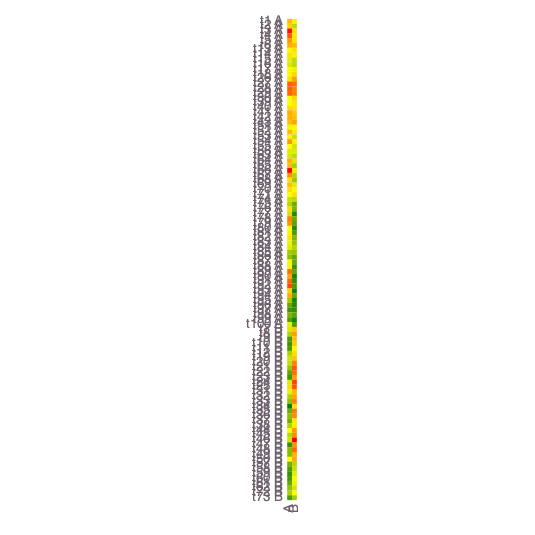

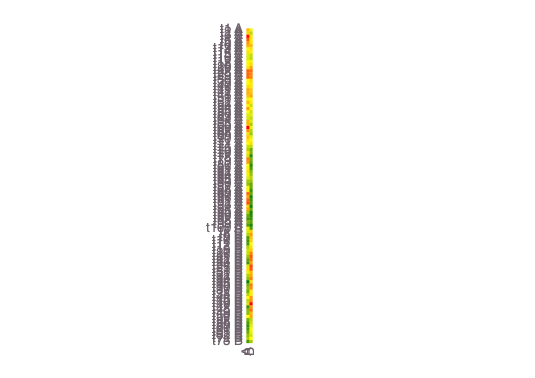

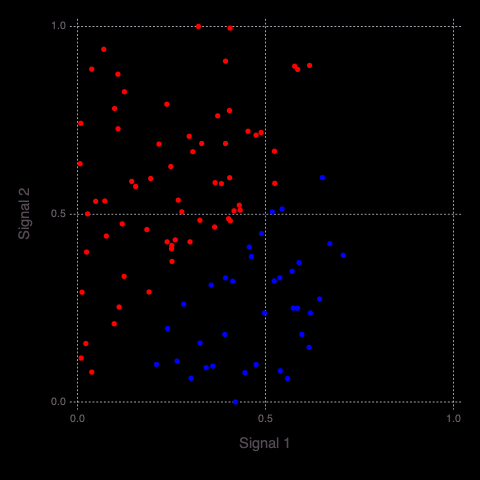

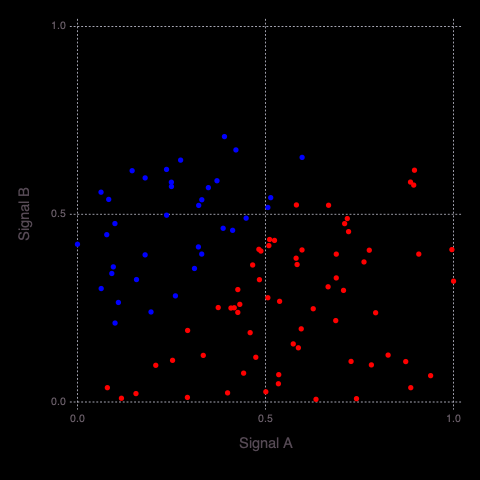

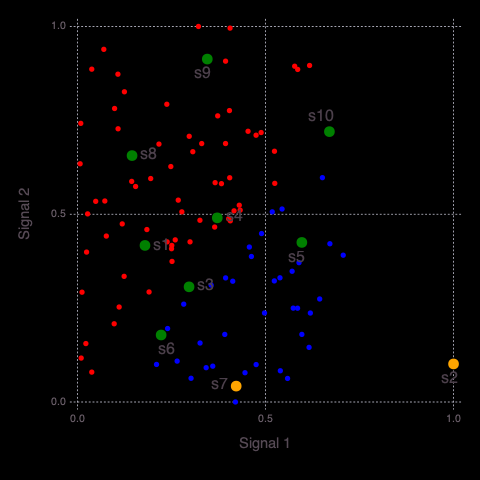

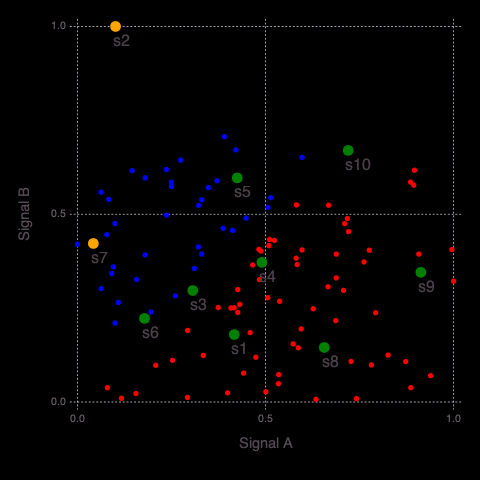

Signal importance (high->low): [2, 3, 1]


┌ Info: Number of signals: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:164
┌ Info: Sensors (signals=3)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:168
┌ Warning: File ./Hmatrix-3-3_10-1000.jld does not exist! Robust k-means analysis will be executed ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:74
┌ Info: Robust k-means analysis results are saved in file ./Hmatrix-3-3_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:100
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: File ./Wmatrix-3-3_100-1000.jld does not exist! Robust k-means analysis will be executed .

3×2 Matrix{Any}:
 "s4"  1.0
 "s5"  0.915499
 "s3"  0.667749

5×2 Matrix{Any}:
 "s8"   1.0
 "s9"   0.79109
 "s1"   0.61774
 "s10"  0.608085
 "s6"   0.202659

2×2 Matrix{Any}:
 "s2"  1.0
 "s7"  0.4245

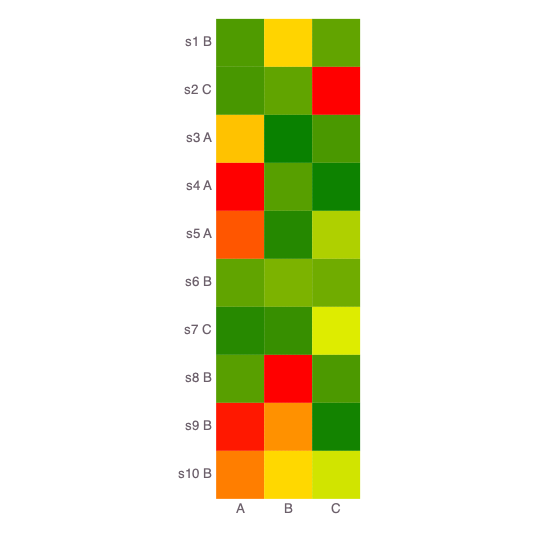

┌ Info: Robust k-means analysis results are saved in file ./Wmatrix-3-3_100-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:100
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Info: Signal B -> A Count: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A -> B Count: 5
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal C -> C Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A (S2) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292
┌ Info: Signal B (S3) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292
┌ Info: Signal C (S1) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292


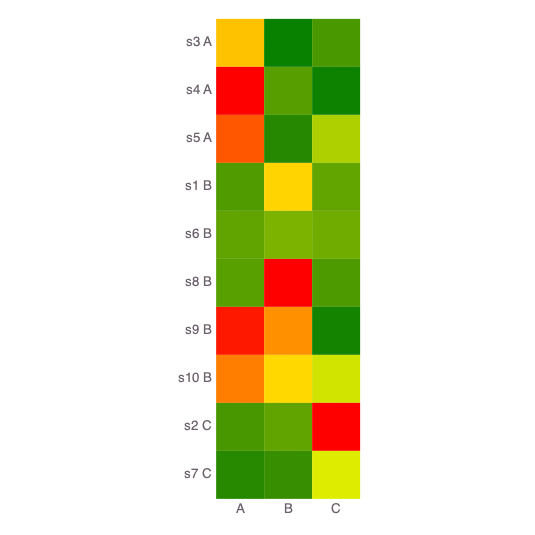

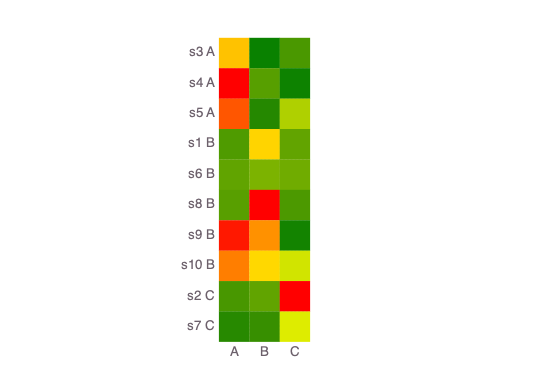

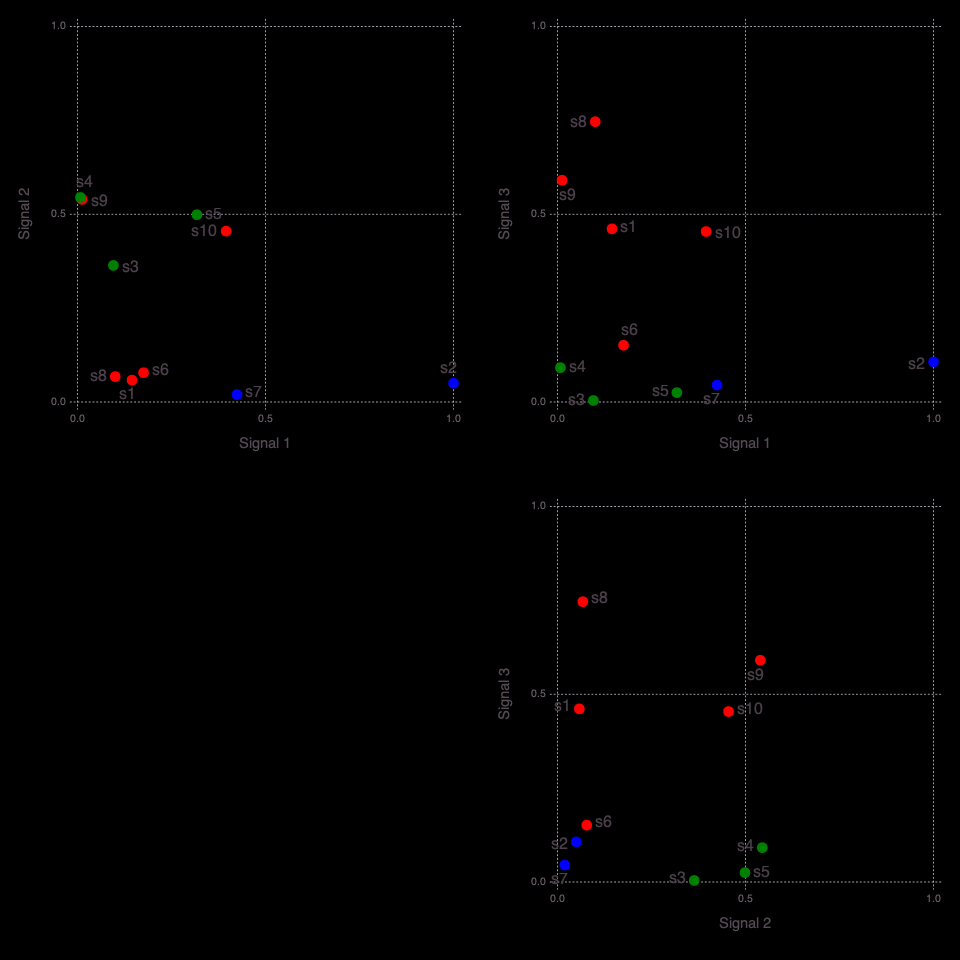

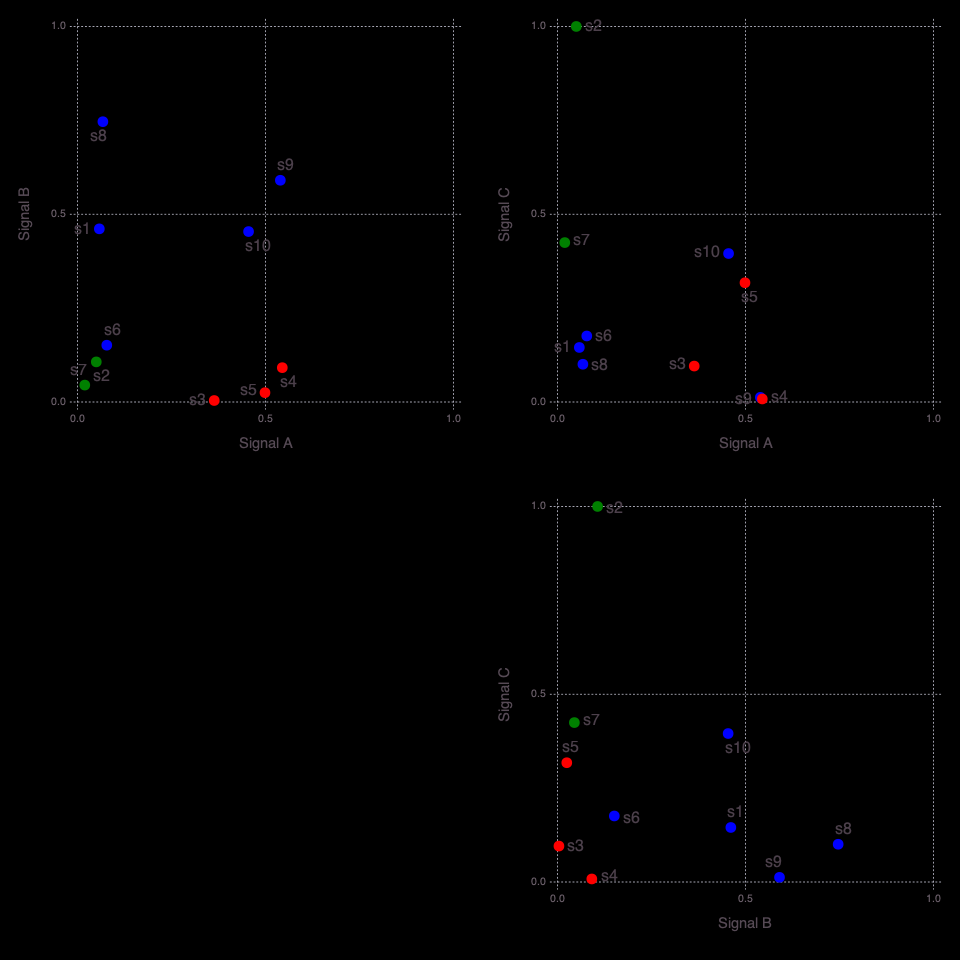

37×2 Matrix{Any}:
 "t27"   1.0
 "t3"    0.996301
 "t66"   0.971245
 "t29"   0.907703
 "t28"   0.907556
 "t4"    0.898674
 "t89"   0.866861
 "t5"    0.821095
 "t69"   0.813855
 "t92"   0.804378
 "t94"   0.75174
 "t43"   0.708383
 "t91"   0.692903
 ⋮       
 "t65"   0.502089
 "t68"   0.495228
 "t76"   0.48642
 "t2"    0.435835
 "t93"   0.435653
 "t100"  0.424621
 "t81"   0.377014
 "t63"   0.35528
 "t75"   0.281262
 "t95"   0.240285
 "t96"   0.172016
 "t99"   0.0751611

23×2 Matrix{Any}:
 "t41"  1.0
 "t16"  0.988476
 "t15"  0.964959
 "t40"  0.960083
 "t53"  0.957865
 "t17"  0.900471
 "t14"  0.849653
 "t55"  0.834555
 "t39"  0.828956
 "t30"  0.810997
 "t77"  0.804218
 "t80"  0.7863
 "t18"  0.750464
 "t51"  0.657356
 "t56"  0.652796
 "t13"  0.6515
 "t38"  0.629279
 "t31"  0.628595
 "t19"  0.529062
 "t57"  0.419718
 "t37"  0.413572
 "t58"  0.23137
 "t34"  0.108903

40×2 Matrix{Any}:
 "t35"  1.0
 "t36"  0.992154
 "t24"  0.981954
 "t25"  0.977369
 "t33"  0.975431
 "t21"  0.96166
 "t46"  0.953169
 "t20"  0.934378
 "t22"  0.92257
 "t32"  0.911171
 "t44"  0.858272
 "t45"  0.856264
 "t48"  0.852365
 ⋮      
 "t62"  0.47024
 "t70"  0.450389
 "t72"  0.401947
 "t74"  0.322782
 "t73"  0.265025
 "t84"  0.238196
 "t83"  0.208642
 "t85"  0.173543
 "t87"  0.121654
 "t86"  0.105959
 "t98"  0.0996115
 "t97"  0.0357299

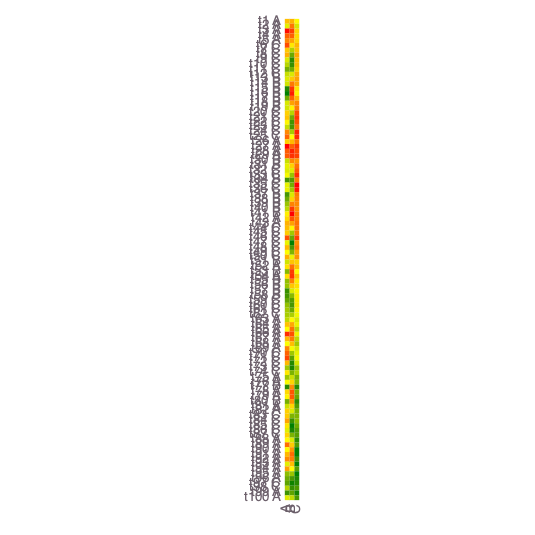

┌ Info: Times (signals=3)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:350
┌ Info: Signal A (S1) Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B (S2) Count: 37
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal C (S3) Count: 23
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B -> A Count: 37
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal C -> B Count: 23
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A -> C Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal B (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal C (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388


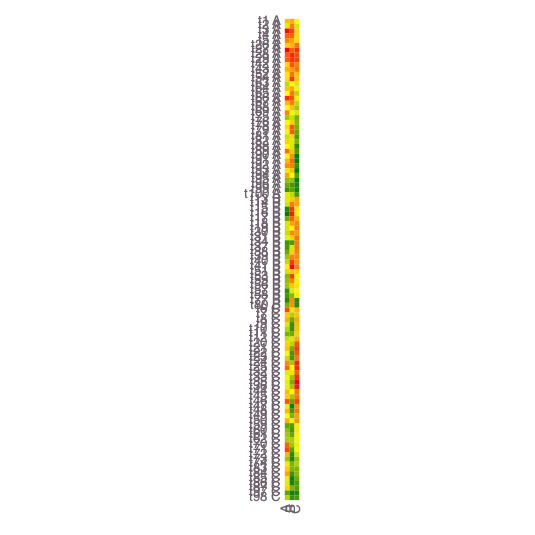

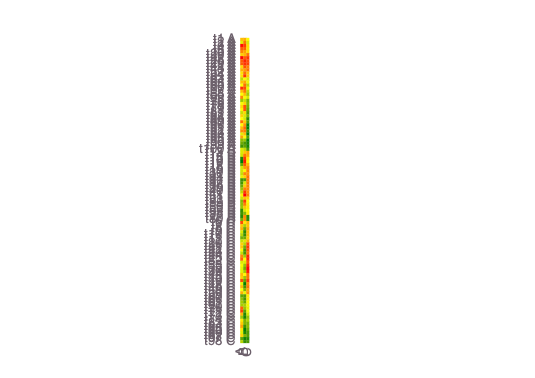

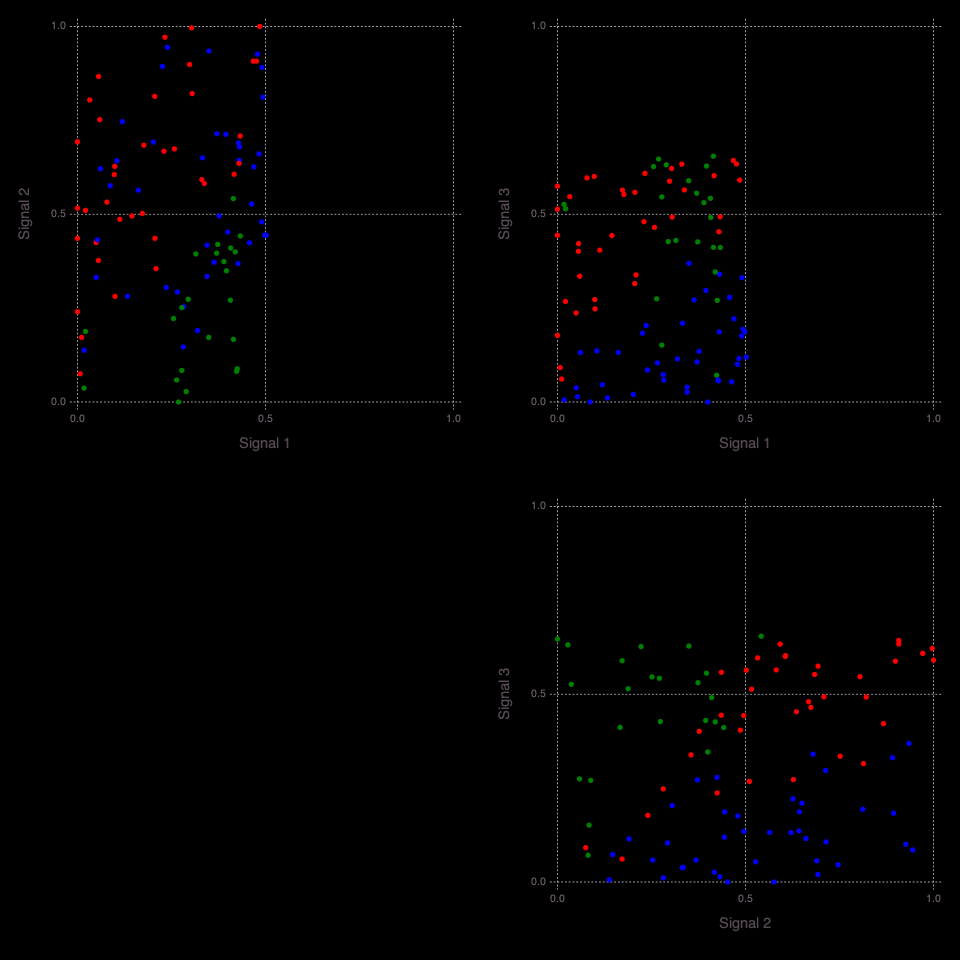

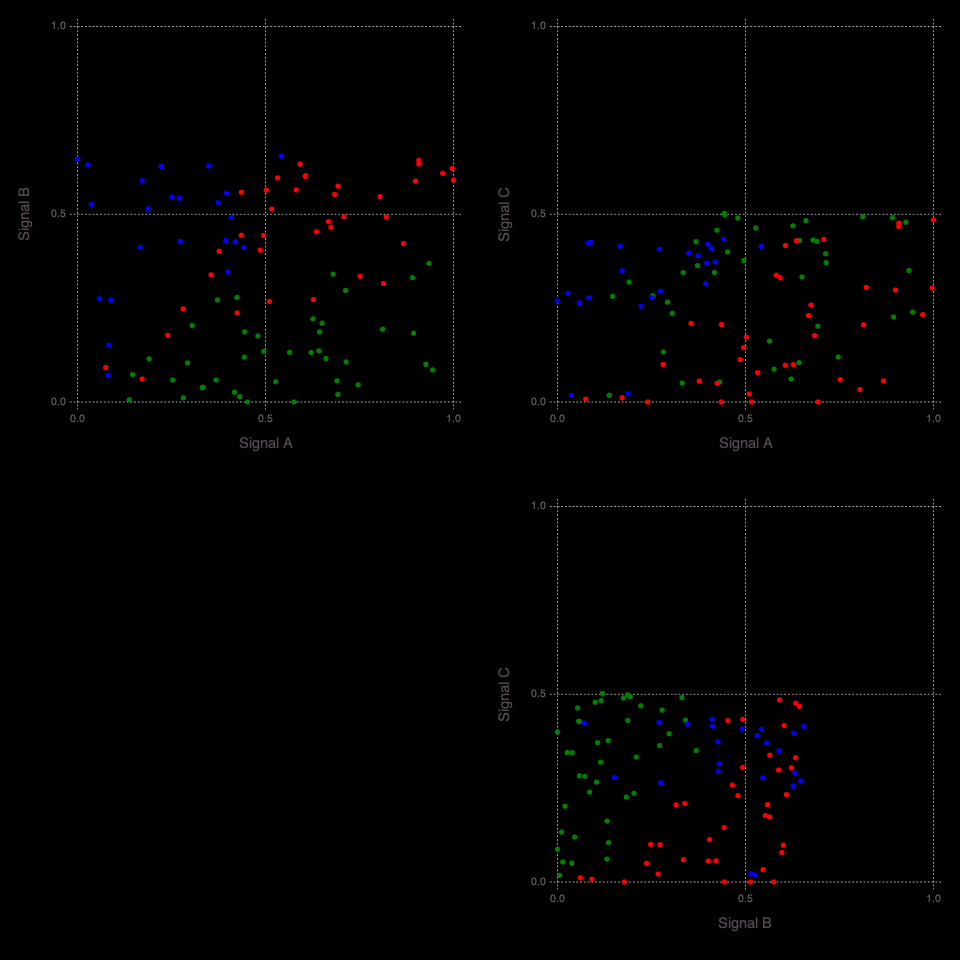

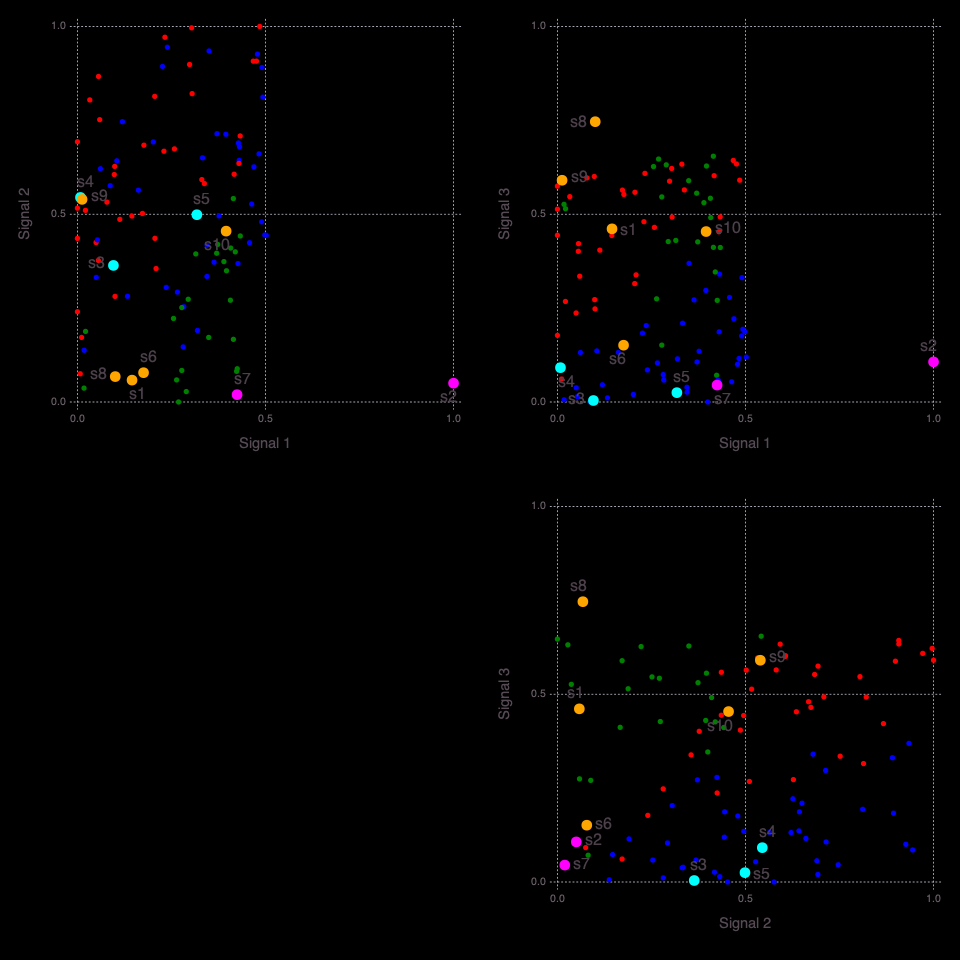

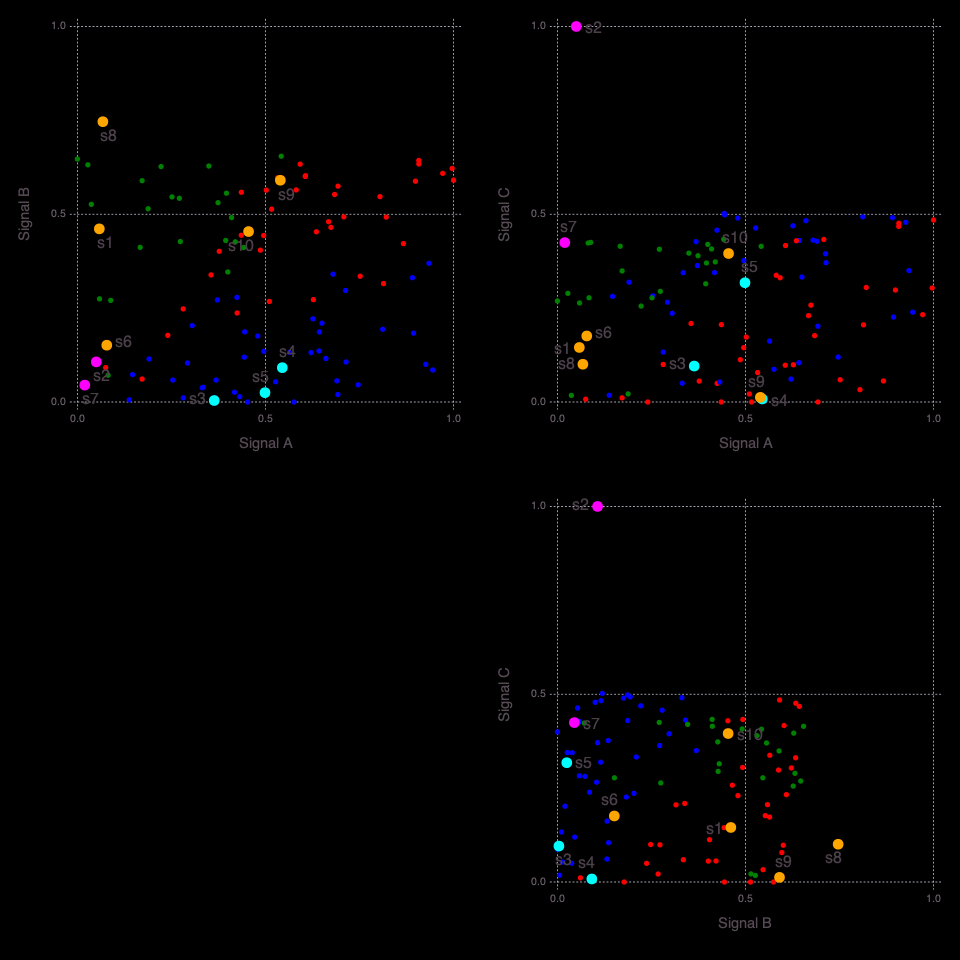

Signal importance (high->low): [4, 1, 2, 3]


┌ Info: Number of signals: 4
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:164
┌ Info: Sensors (signals=4)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:168
┌ Warning: File ./Hmatrix-4-4_10-1000.jld does not exist! Robust k-means analysis will be executed ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:74
┌ Info: Robust k-means analysis results are saved in file ./Hmatrix-4-4_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:100
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.ju

2×2 Matrix{Any}:
 "s5"  1.0
 "s3"  0.799532

3×2 Matrix{Any}:
 "s8"  1.0
 "s9"  0.79028
 "s1"  0.601962

┌ Info: Robust k-means analysis results are saved in file ./Wmatrix-4-4_100-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:100
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Info: Signal D -> A Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A -> B Count: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal B -> C Count: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal C -> D Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A (S4) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292
┌ Info: Signal B (S1) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.

3×2 Matrix{Any}:
 "s4"   1.0
 "s10"  0.613947
 "s6"   0.201276

2×2 Matrix{Any}:
 "s2"  1.0
 "s7"  0.399474

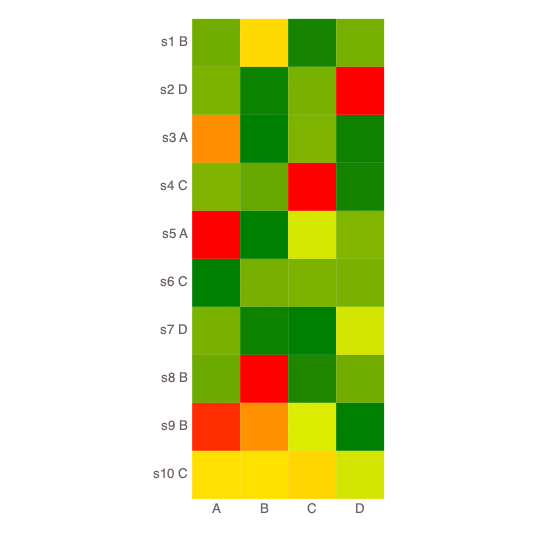

┌ Info: Signal D (S3) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292


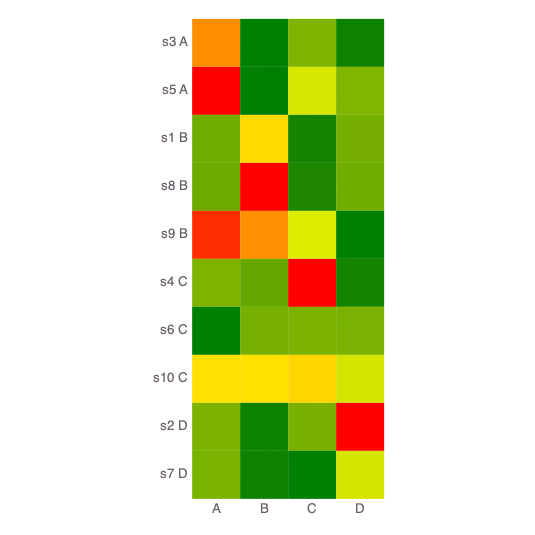

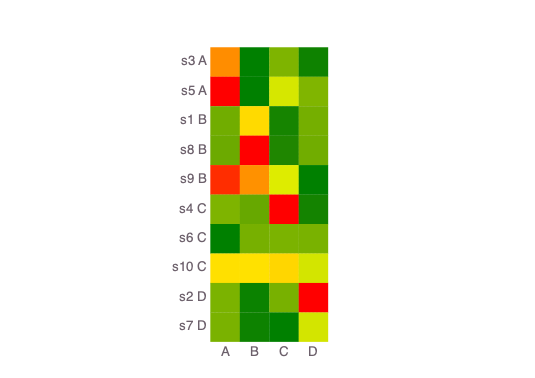

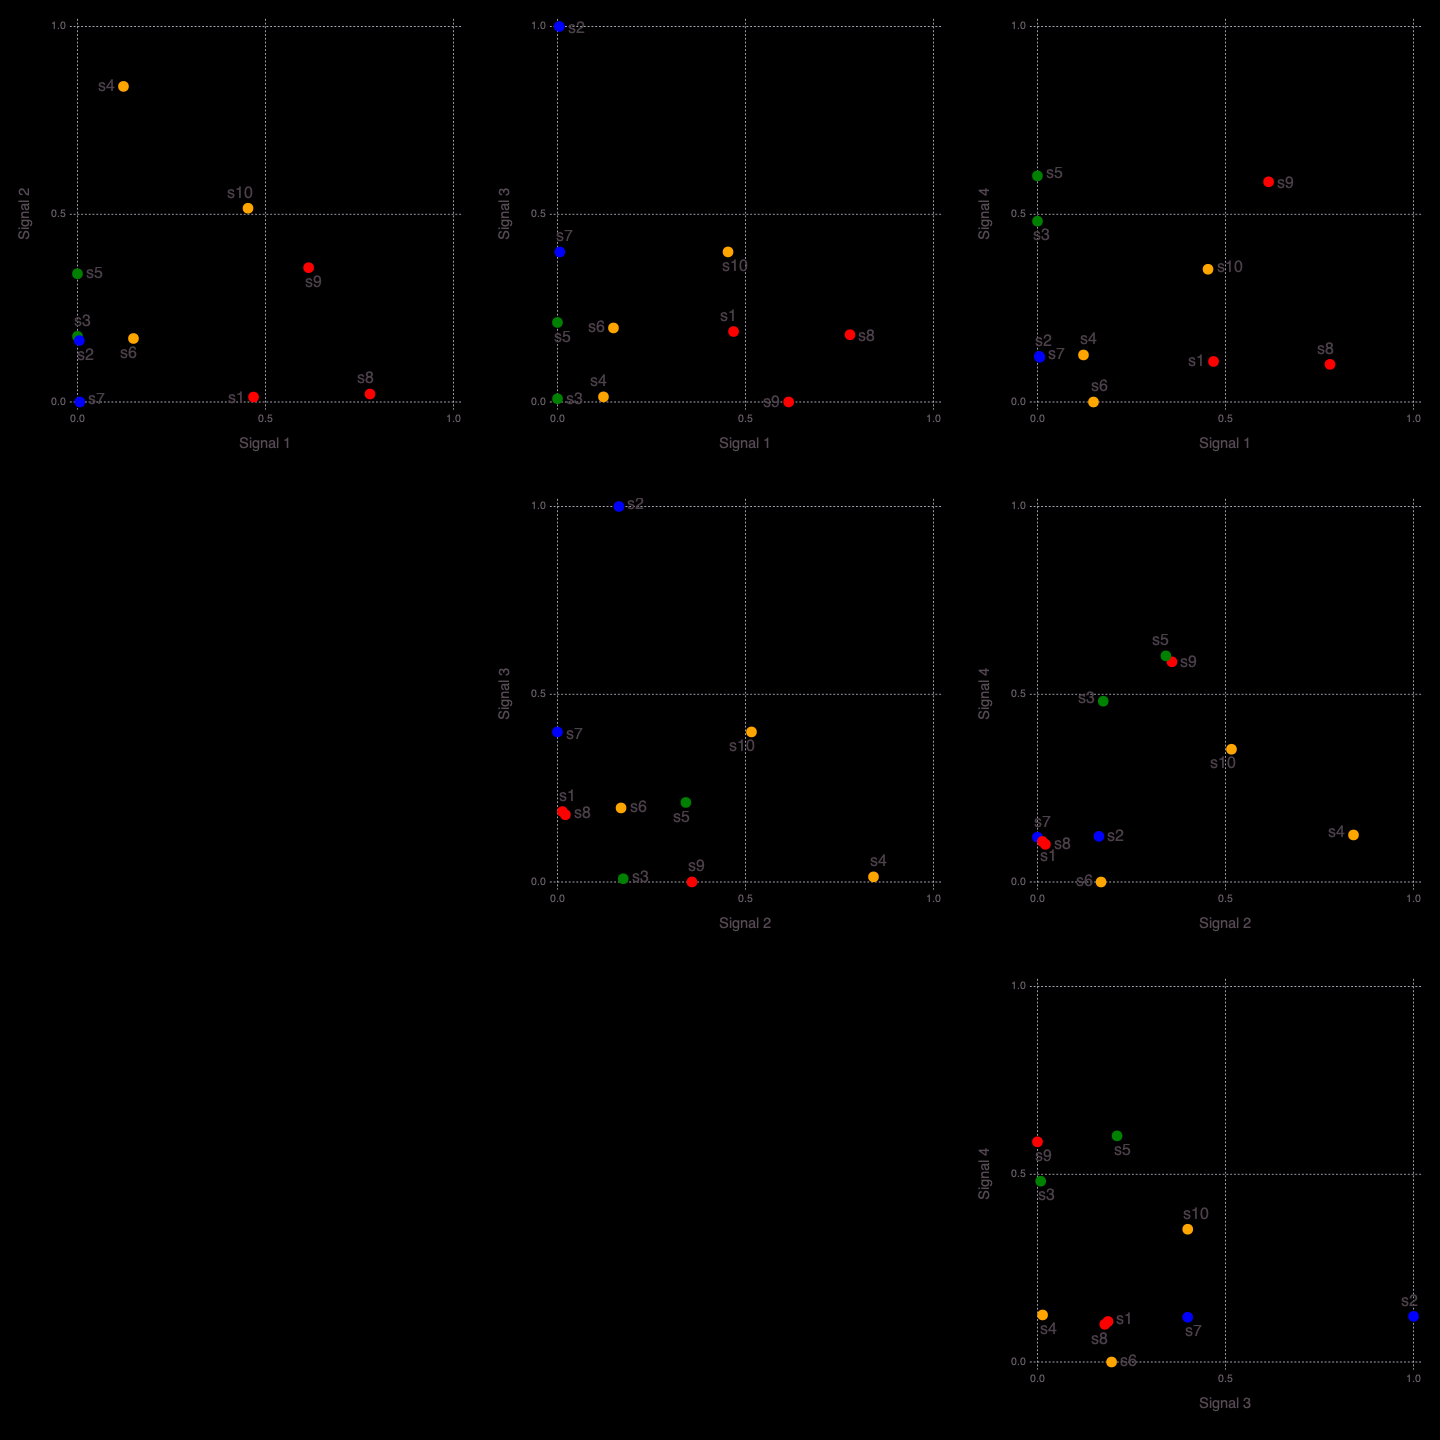

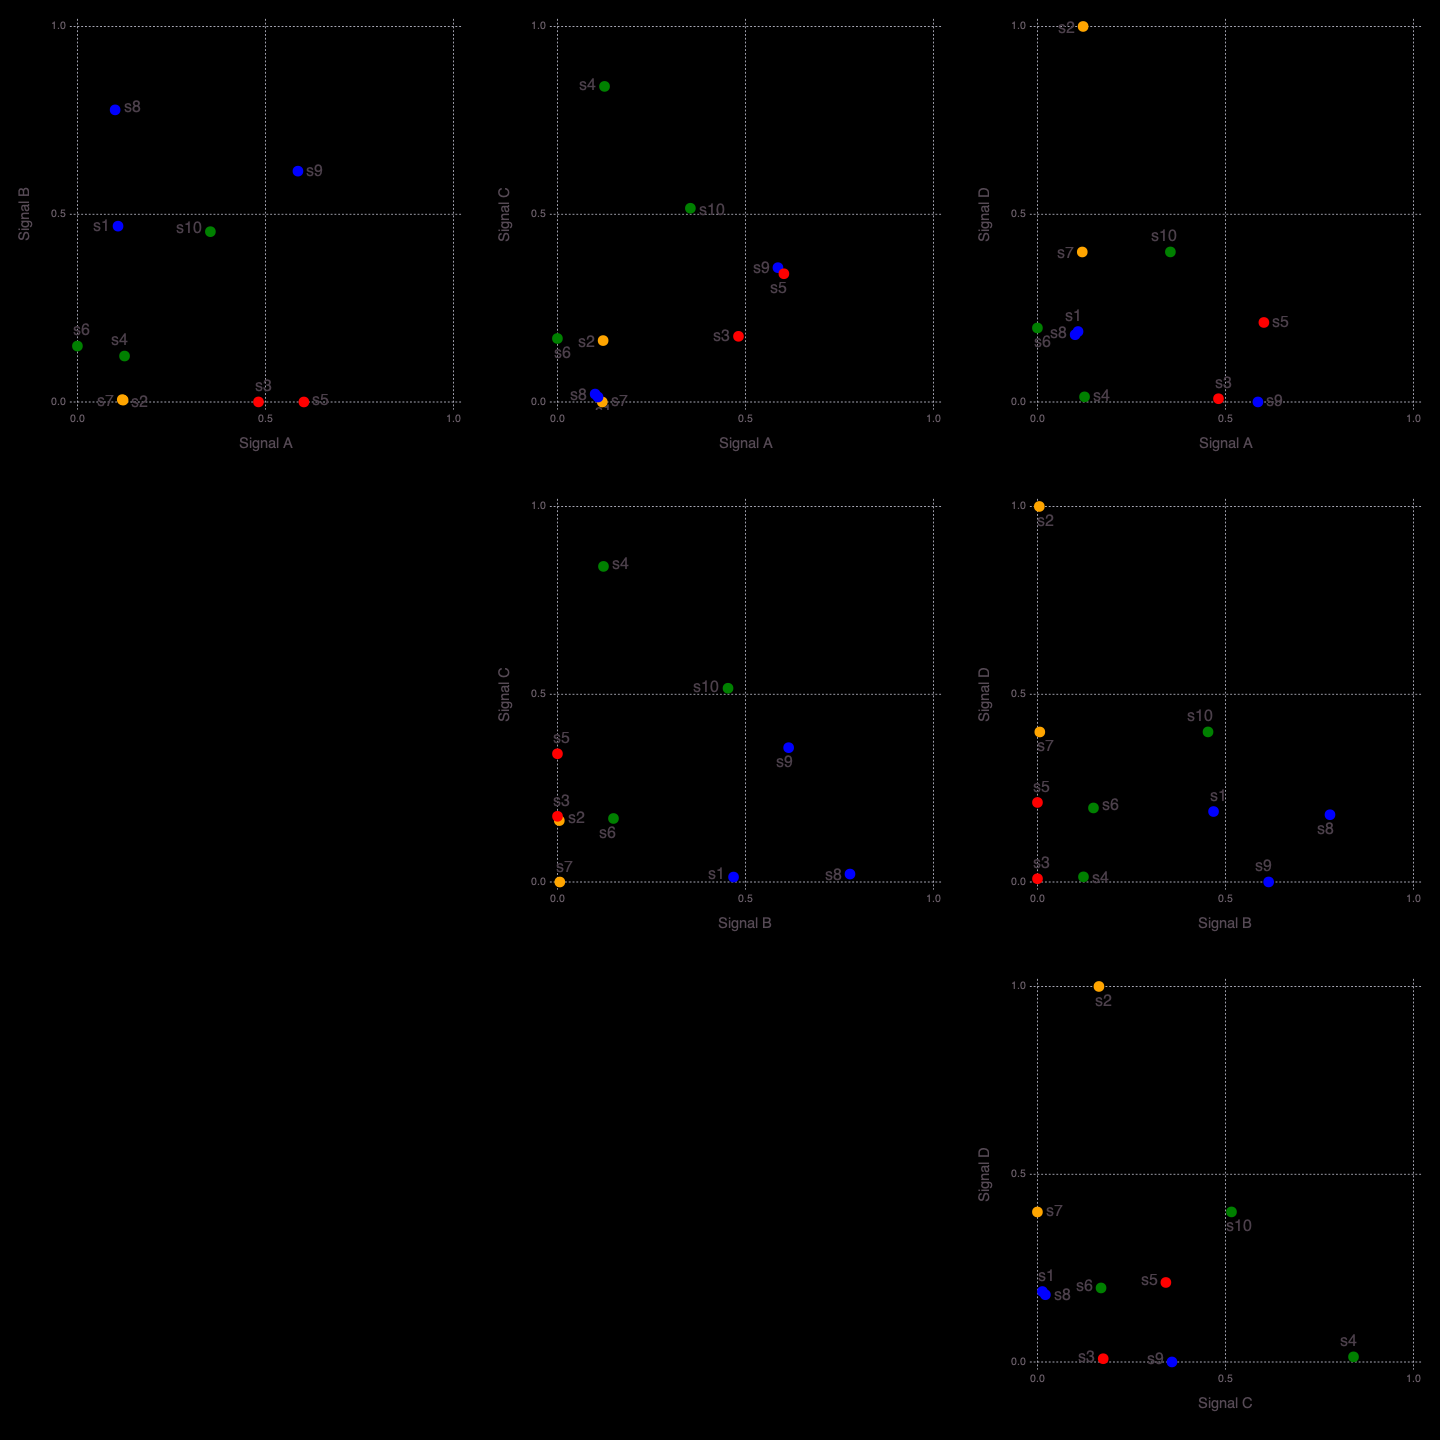

27×2 Matrix{Any}:
 "t71"   0.99842
 "t36"   0.917673
 "t20"   0.904744
 "t46"   0.894263
 "t35"   0.884538
 "t82"   0.880886
 "t84"   0.872824
 "t21"   0.843684
 "t6"    0.838251
 "t94"   0.826204
 "t25"   0.818714
 "t70"   0.807446
 "t83"   0.805781
 ⋮       
 "t100"  0.720112
 "t74"   0.676008
 "t72"   0.661477
 "t50"   0.608804
 "t8"    0.608108
 "t44"   0.581842
 "t98"   0.553569
 "t85"   0.445068
 "t60"   0.418785
 "t61"   0.372216
 "t59"   0.305934
 "t97"   0.129773

40×2 Matrix{Any}:
 "t41"  1.0
 "t28"  0.990217
 "t3"   0.990052
 "t79"  0.985958
 "t78"  0.985492
 "t66"  0.985395
 "t54"  0.982794
 "t16"  0.982776
 "t29"  0.968168
 "t53"  0.967117
 "t15"  0.958085
 "t40"  0.955911
 "t42"  0.918322
 ⋮      
 "t13"  0.622565
 "t31"  0.603464
 "t38"  0.58695
 "t19"  0.480153
 "t75"  0.395829
 "t57"  0.393706
 "t12"  0.373994
 "t32"  0.371084
 "t37"  0.346155
 "t62"  0.298608
 "t58"  0.182046
 "t99"  0.152601

21×2 Matrix{Any}:
 "t68"  1.0
 "t89"  0.994724
 "t90"  0.989127
 "t5"   0.986953
 "t26"  0.982561
 "t67"  0.976628
 "t88"  0.971565
 "t69"  0.961725
 "t4"   0.959983
 "t91"  0.925882
 "t87"  0.892837
 "t92"  0.819875
 "t65"  0.811626
 "t2"   0.790523
 "t86"  0.789248
 "t30"  0.705488
 "t93"  0.695834
 "t51"  0.694574
 "t63"  0.52366
 "t95"  0.390014
 "t96"  0.245916

12×2 Matrix{Any}:
 "t34"  1.0
 "t23"  0.963279
 "t22"  0.951511
 "t45"  0.89329
 "t47"  0.859631
 "t48"  0.845018
 "t49"  0.824024
 "t11"  0.764273
 "t10"  0.744935
 "t9"   0.723564
 "t7"   0.674474
 "t73"  0.260176

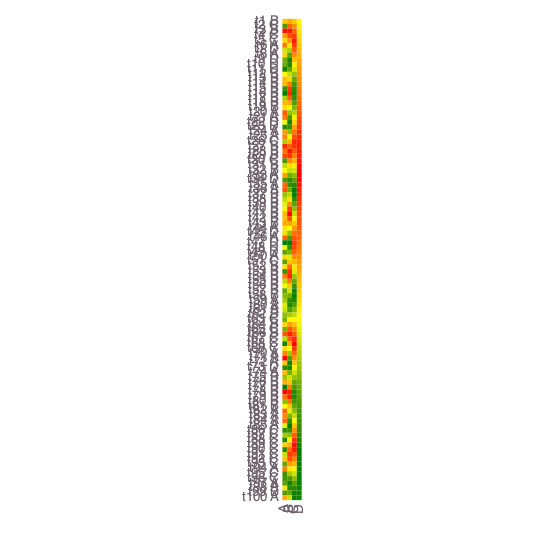

┌ Info: Times (signals=4)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:350
┌ Info: Signal A (S1) Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B (S4) Count: 27
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal C (S2) Count: 21
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal D (S3) Count: 12
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B -> A Count: 27
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A -> B Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal C -> C Count: 21
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal D -> D Count: 12
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal B (remapped k-means cluste

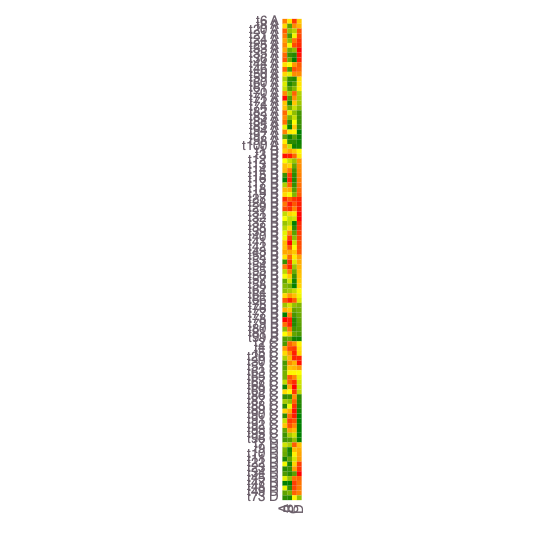

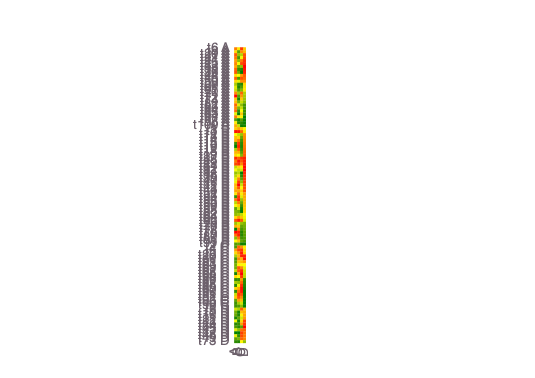

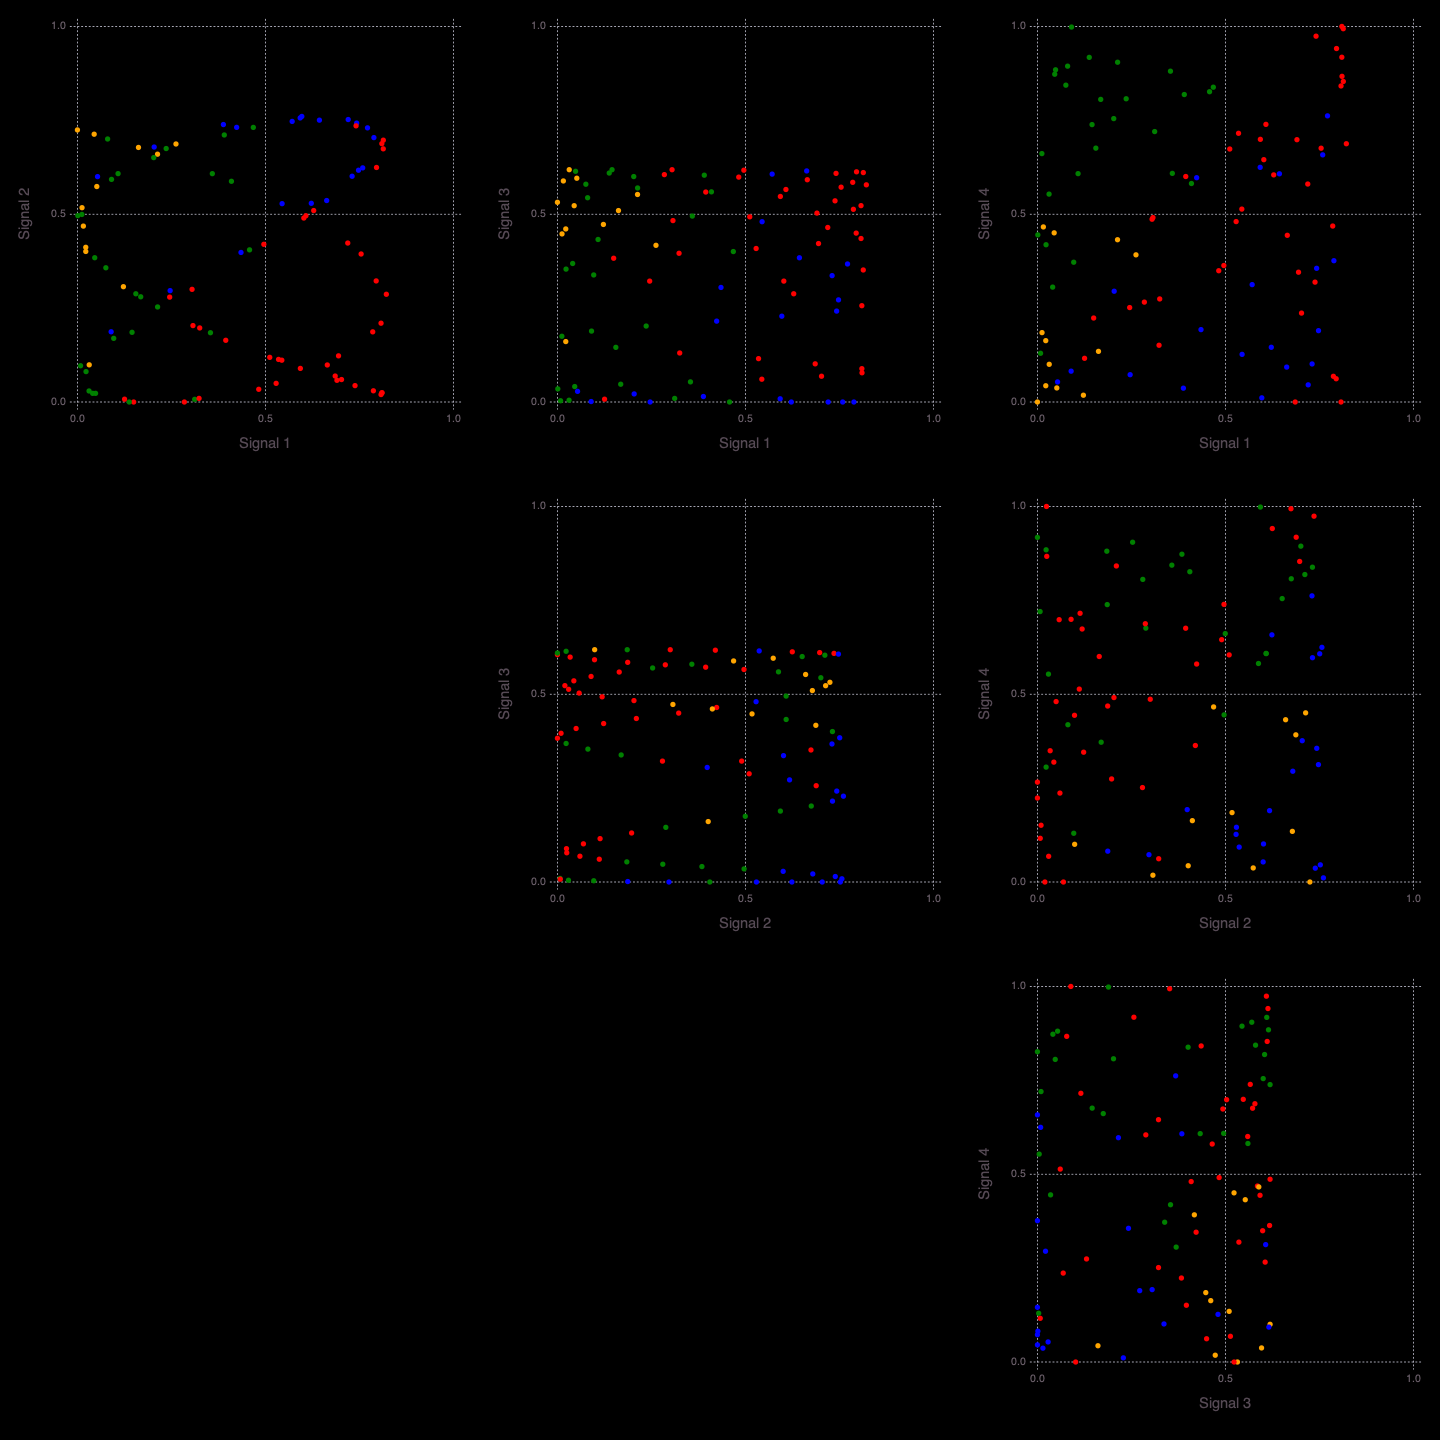

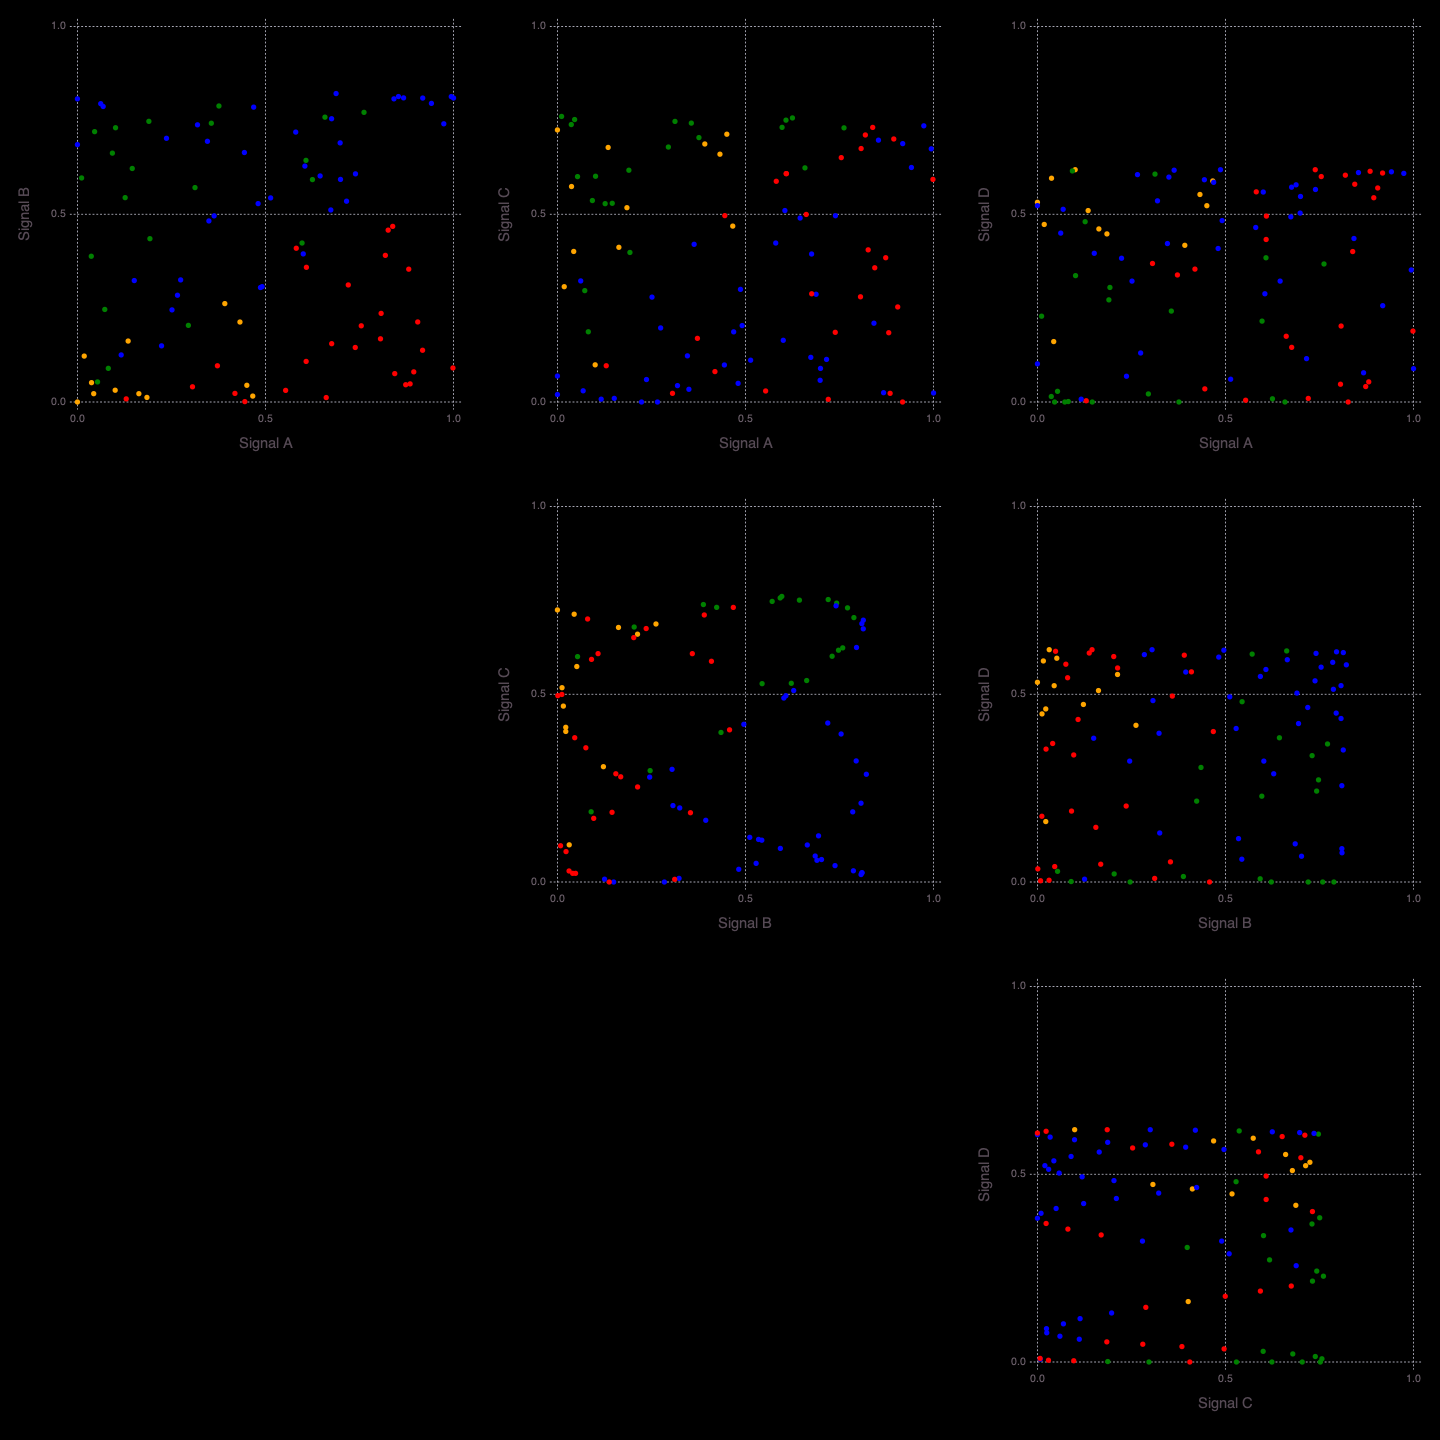

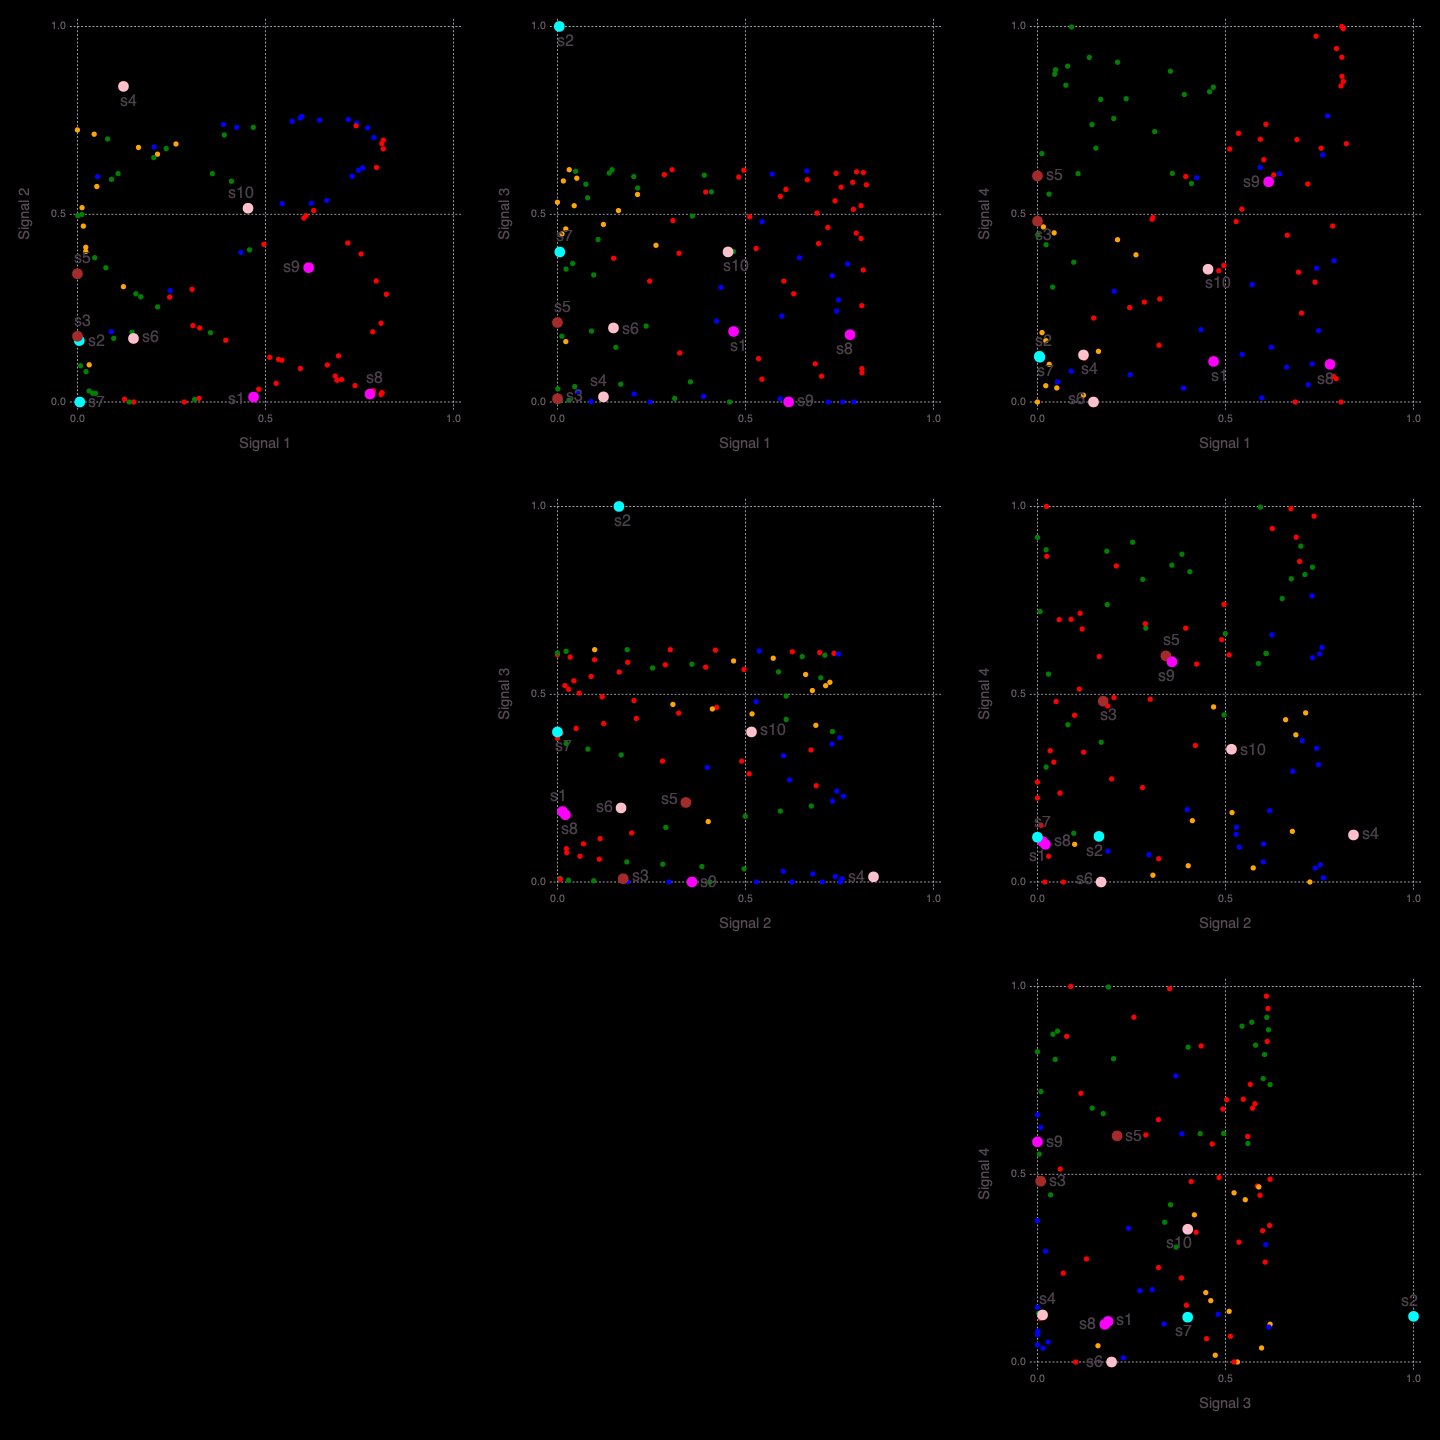

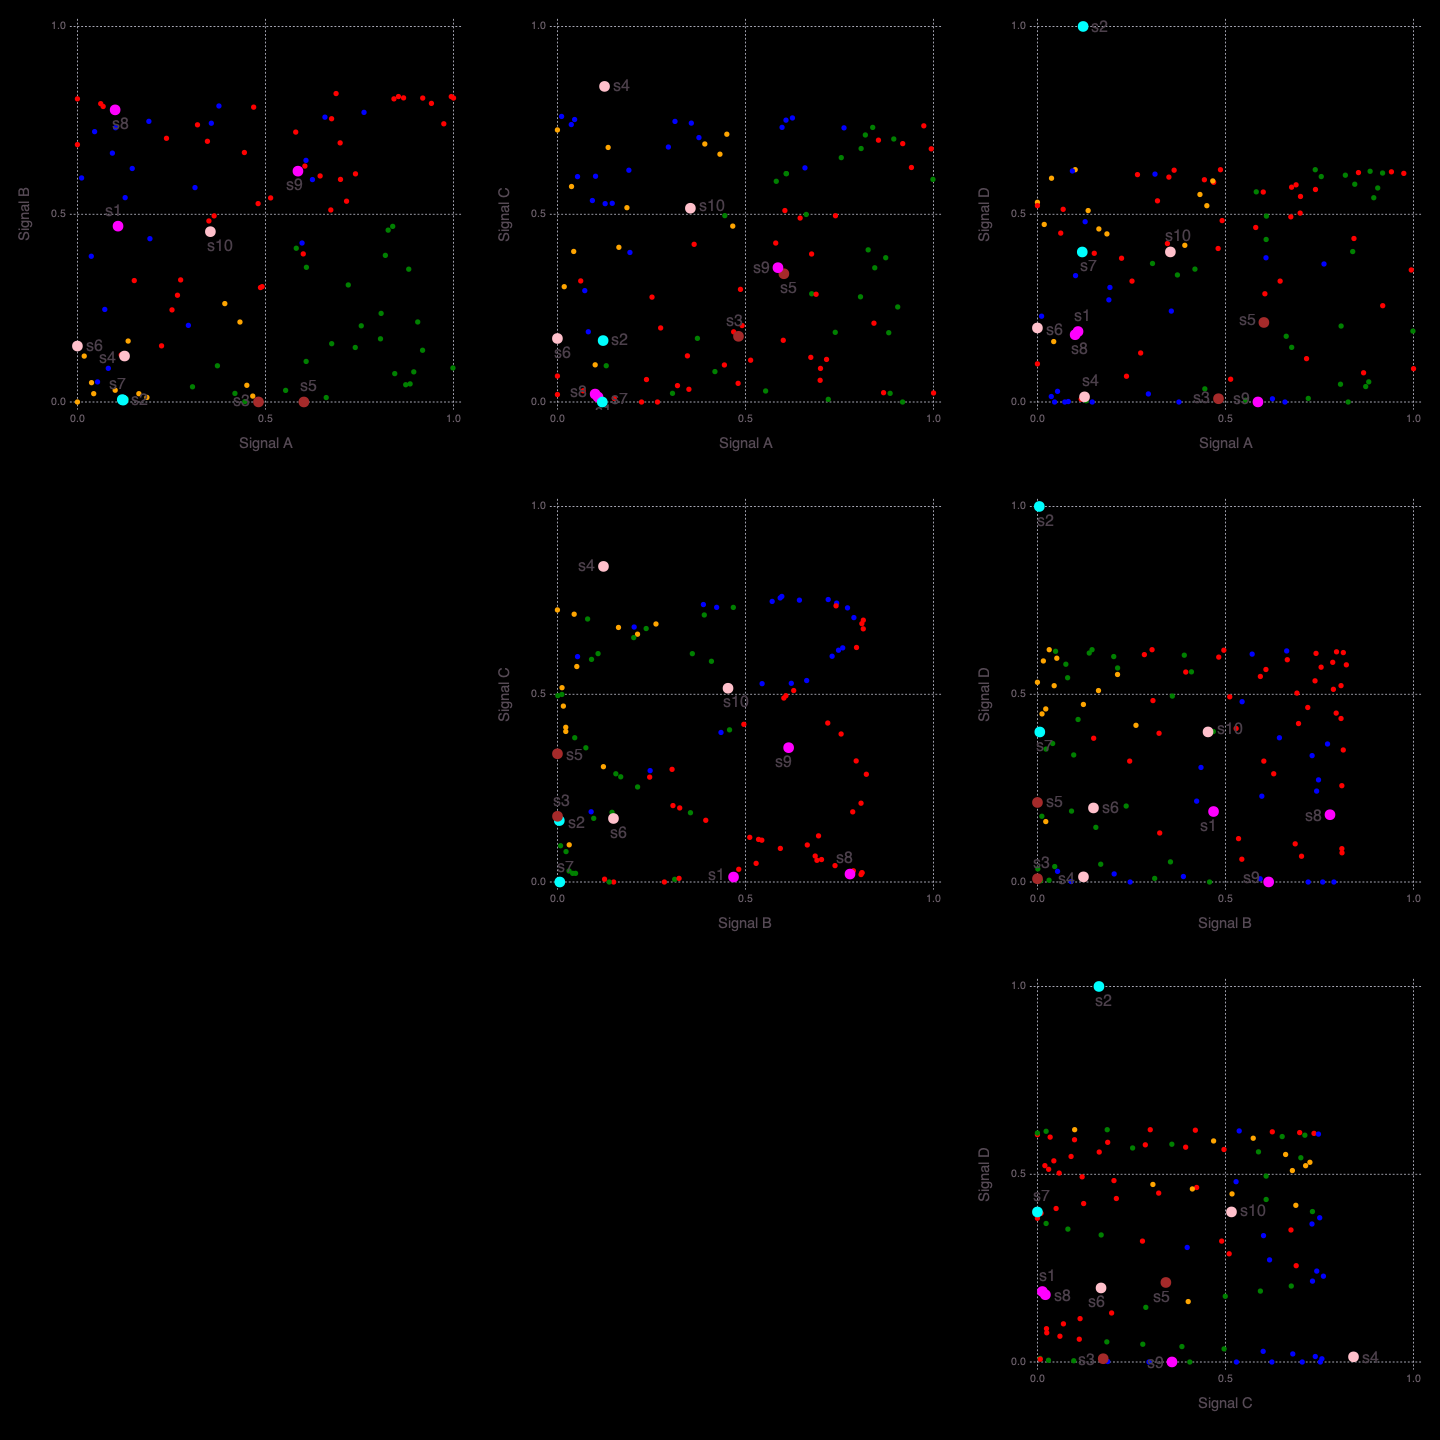

([[2, 1], [2, 3, 1], [4, 1, 2, 3]], [['A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B'  …  'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], ['A', 'A', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'C'  …  'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'A'], ['B', 'C', 'B', 'C', 'C', 'A', 'D', 'A', 'D', 'D'  …  'C', 'C', 'C', 'A', 'C', 'C', 'A', 'A', 'B', 'A']], [['A', 'B', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A'], ['B', 'C', 'A', 'A', 'A', 'B', 'C', 'B', 'B', 'B'], ['B', 'D', 'A', 'C', 'A', 'C', 'D', 'B', 'B', 'C']])

In [14]:
NMFk.clusterresults(NMFk.getks(nkrange, robustness[nkrange]), We, He, "t" .* string.(collect(1:100)), "s" .* string.(collect(1:10)); Wcasefilename="times", Hcasefilename="sensors", biplotcolor=:WH, sortmag=false, biplotlabel=:H, point_size_nolabel=2Gadfly.pt, point_size_label=4Gadfly.pt)